This notebook was inspired by neural network & machine learning labs led by [GMUM](https://gmum.net/).

See also [An overview of gradient descent optimization algorithms](https://ruder.io/optimizing-gradient-descent/index.html), section 8.3 of [Chapter 8](https://www.deeplearningbook.org/contents/optimization.html) of the Deep Learning book, [Why Momentum Really Works](https://distill.pub/2017/momentum/), and the [second video](https://www.youtube.com/watch?v=IHZwWFHWa-w) from the 3Blue1Brown playlist on neural networks.

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from utils import visualize_optimizer, test_optimizer

# Optimization

Now that we’ve seen how to compute derivatives of the cost function with
respect to model parameters last class, what do we do with those derivatives? 

Today we'll talk about several popular optimization methods. One thing that's perhaps important to note before we get started -- in mathematical optimization in general, the only thing we care about is optimizing some function we know. This is not usually the case in deep learning (or machine learning in general) -- we have access to a measure of performance on the training set, but what we really care about is generalization.
 

[]()                       |  []()
:-------------------------:|:-------------------------:
![](figures/contours_evaluation_optimizers.gif)  |  ![](figures/saddle_point_evaluation_optimizers.gif)

<center>Visualization of several popular optimizers. Source: <a href="https://ruder.io/optimizing-gradient-descent/index.html">An overview of gradient descent optimization algorithms</a>.</center>

Your task today will be to implement some of the most popular optimizers in deep learning. Each of the classes you'll be implementing inherits from the `Optimizer` class, which already has some needed functionality. You'll need to overload the `step` method and create some variables in the constructor.

In [2]:
class Optimizer:
    """Base class for each optimizer"""
    
    def __init__(self, initial_params):
        # store initial model weights
        self.params = initial_params
    
    def step(self):
        """Updates the weights stored in self.params"""
        raise NotImplementedError()
         
    def zero_grad(self):
        """Torch accumulates gradients, so we need to clear them after every update"""
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

## Example: SGD
SGD has one hyperparameter $\eta$, which corresponds to the learning rate: $\mathbf{\theta_{new}}=\mathbf{\theta_{old}} -\eta \mathbf{g}$, where $\mathbf{g}=\nabla_\mathbf{\theta} L(\mathbf{\theta})$.


In [3]:
from typing import List

class GradientDescent(Optimizer):
    
    def __init__(self, initial_params: List[torch.tensor], learning_rate):
        super().__init__(initial_params)
        self.learning_rate = learning_rate
    
    @torch.no_grad()
    def step(self):
        for param in self.params:
            param -= self.learning_rate * param.grad
            # Please note that it's important to change the parameters in-place (-=) so the original tensors are modified

The cell below will tell you whether the optimizer works correctly.

In [4]:
test_optimizer(GradientDescent)

The following cell will visualize the optimization trajectory.

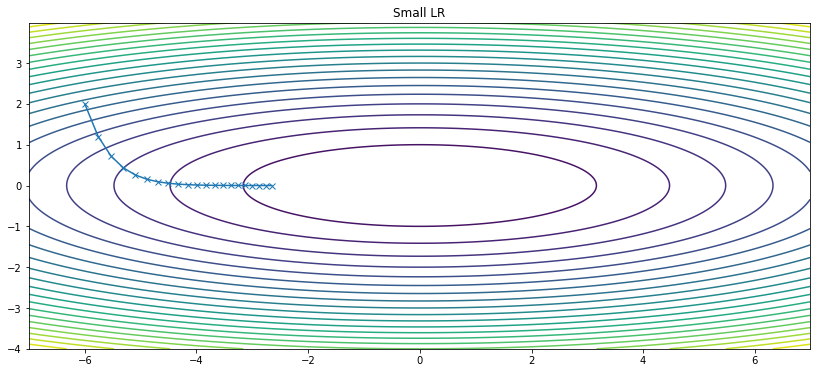

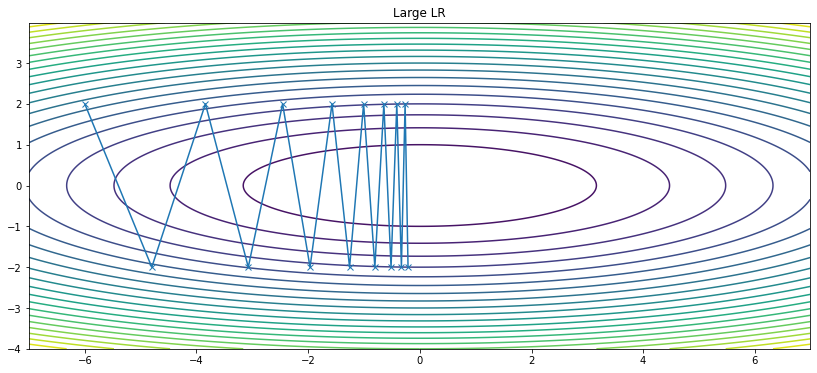

In [5]:
visualize_optimizer(GradientDescent, n_steps=20, learning_rate=0.1, title='Small LR')
visualize_optimizer(GradientDescent, n_steps=15, learning_rate=0.5, title='Large LR')

## Task 1 (0.25p): Momentum
As we can see above, SGD can have trouble navigating ravines -- areas where the surface curves much more steeply in one dimension than in another. In such scenarios, SGD oscillates across the slopes of the ravine while only making meagre progress towards the local optimum. Momentum is a method to dampen these oscillations by introducing memory into the update rule (think of a ball rolling down a hill):

$$\mathbf{v_{new}} = \gamma \mathbf{v_{old}} + \eta \mathbf{g},$$

$$\mathbf{\theta_{new}}=\mathbf{\theta_{old}}-\mathbf{v_{new}}.$$

The momentum $\gamma$ is usually set to $0.9$ (always less than $1$), whereas the learning rate $\eta$ usually ranges from $0.001$ to $0.01$. The initial $\mathbf{v}$ should be initialized to zeroes (one $\mathbf{v}$ for each parameter with the same shape as that parameter; use `torch.zeros_like`).

In [6]:
class Momentum(Optimizer):
    
    def __init__(self, initial_params, learning_rate, gamma):
        super().__init__(initial_params)
        
        self.learning_rate = learning_rate
        self.gamma = gamma
        
        self.vs = [torch.zeros_like(params) for params in self.params]
    
    @torch.no_grad()
    def step(self):
        # hint: zip is useful if you want to iterate over two lists at once
        for param, v in zip(self.params, self.vs):
            v *= self.gamma
            v += self.learning_rate * param.grad
            param -= v

In [7]:
test_optimizer(Momentum)

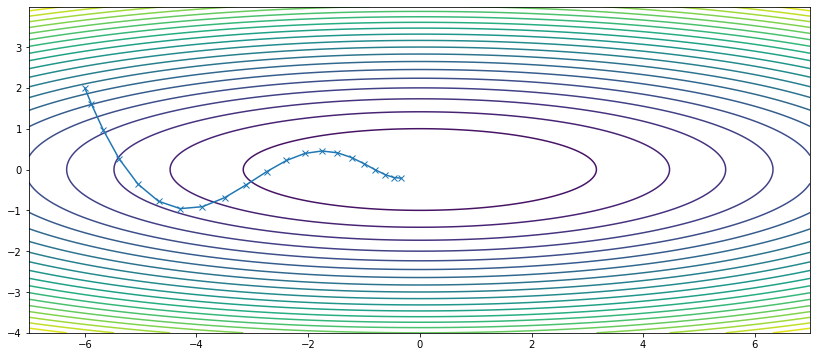

In [8]:
visualize_optimizer(Momentum, n_steps=20, learning_rate=0.05, gamma=0.8)

## Task 2 (0.25p): Adagrad
One problem with the above methods is that the same learning rate applies to all parameter updates. If our data is sparse and our features have very different frequencies, we might not want to update all of them to the same extent (we'd like to perform smaller updates to features ocurring more frequently and larger updates to rare features). Adagrad fixes this by using a different learning rate for every parameter based on the sum of squares of the gradients so far:

$$\mathbf{r_{new}} = \mathbf{r_{old}} + \mathbf{g}^2,$$

$$\mathbf{\theta_{new}}=\mathbf{\theta_{old}}-\frac{\eta}{\sqrt{\mathbf{r_{new}+\epsilon}}}\cdot \mathbf{g},$$
where the relevant multiplications are done element-wise.

Adagrad has two hyperparameters:
- the global learning rate $\eta$, typically from $0.001$ to $0.01$,
- $\epsilon$ -- used to prevent division by $0$, typically set to $10^{-8}$.

The initial $\mathbf{r}$ should be set to a tensor of zeroes with the same shape as a given parameter.

In [9]:
class Adagrad(Optimizer):
    
    def __init__(self, initial_params, learning_rate, epsilon):
        super().__init__(initial_params)
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        
        self.rs = [torch.zeros_like(params) for params in self.params]
    
    @torch.no_grad()
    def step(self):
        for param, r in zip(self.params, self.rs):
            r += param.grad ** 2
            param -= self.learning_rate * (param.grad / torch.sqrt(r + self.epsilon))

In [10]:
test_optimizer(Adagrad)

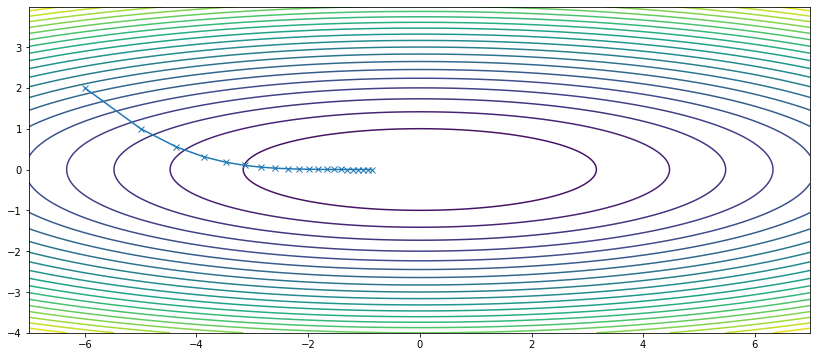

In [11]:
visualize_optimizer(Adagrad, n_steps=20, learning_rate=1.0, epsilon=1e-8)

## Task 3 (0.25p): RMSProp
Adagrad's main weakness is its accumulation of the squared gradients in the denominator. As we keep on adding positive terms, the sum keeps growing during training. This, in turn, can result in a premature and excessive decrease in the eﬀective learning rate. RMSProp and Adadelta (another method which we won't talk about here) seek to alleviate this problem, which RMSProp does by using an exponentially decaying average to discard history from the extreme past:

$$\mathbf{r_{new}}=\gamma\mathbf{r_{old}}+(1-\gamma)\mathbf{g}^2,$$

$$\mathbf{\theta_{new}}=\mathbf{\theta_{old}}-\frac{\eta}{\sqrt{\mathbf{r_{new}+\epsilon}}}\cdot \mathbf{g}.$$

RMSProp has three hyperparameters:
- the global learning rate $\eta$, typically set from $0.001$ to $0.01$,
- the moving average coefficient $\gamma$, typically set to $0.9$,
- $\epsilon$ -- used to prevent division by $0$, typically set to $10^{-8}$.

In [12]:
class RMSProp(Optimizer):
    
    def __init__(self, initial_params, learning_rate, gamma, epsilon):
        super().__init__(initial_params)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        
        self.rs = [torch.zeros_like(params) for params in self.params]
    
    @torch.no_grad()
    def step(self):
         for param, r in zip(self.params, self.rs):
            r *= self.gamma
            r += (1. - self.gamma) * param.grad ** 2
            param -= self.learning_rate * (param.grad / torch.sqrt(r + self.epsilon))

In [13]:
test_optimizer(RMSProp)

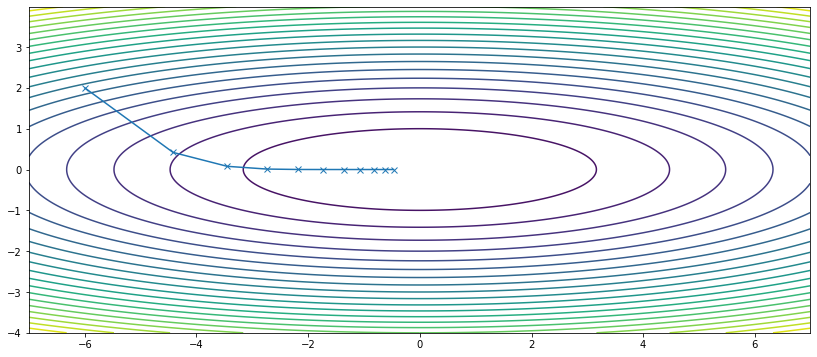

In [14]:
visualize_optimizer(RMSProp, n_steps=10, learning_rate=0.5, gamma=0.9, epsilon=1e-8)

## Task 4 (0.5p): Adam
Adam (cf. _adaptive moments_) is yet another adaptive learning rate optimization algorithm.  In addition to storing an exponentially decaying average of past squared gradients like RMSprop, Adam also keeps an exponentially decaying average of past gradients, similar to momentum. We compute the decaying averages of past and past squared gradients $\mathbf{m}$ and $\mathbf{v}$ respectively as follows:

$$\mathbf{m_{new}}=\beta_1\mathbf{m_{old}}+(1-\beta_1)\mathbf{g},$$

$$\mathbf{v_{new}}=\beta_2\mathbf{v_{old}}+(1-\beta_2)\mathbf{g}^2.$$

These are estimates of the first moment (the mean) and the second moment (the uncentered variance) of the gradients respectively, hence the name of the method. As $\mathbf{m}$ and $\mathbf{v}$ are initialized as vectors of zeroes, these estimates are initially biased towards zero, hence we correct these updates:

$$\hat{\mathbf{m}}_{\mathbf{new}} = \frac{\mathbf{m_{new}}}{1-\beta_1^t},$$
$$\hat{\mathbf{v}}_{\mathbf{new}} = \frac{\mathbf{v_{new}}}{1-\beta_2^t},$$

where $t$ is the current timestep, i.e. $\mathbf{m_{new}}=\mathbf{m_t}$. Then we use these for the actual update:

$$\mathbf{\theta_{new}}=\mathbf{\theta_{old}}-\frac{\eta}{\sqrt{\hat{\mathbf{v}}_{\mathbf{new}}}+\epsilon}\cdot \hat{\mathbf{m}}_{\mathbf{new}}.$$


Adam has four hyperparameters:
- the global learning rate $\eta$, typically set to $0.001$,
* the moving average coefficient of the first moment $\beta_1$, typically 0.9,
* the moving average coefficient of the second moment $\beta_2$, typically 0.999,
- $\epsilon$ -- used to prevent division by $0$, typically set to $10^{-8}$.

In [15]:
class Adam(Optimizer):
   
    def __init__(self, initial_params, learning_rate, beta1, beta2, epsilon):
        super().__init__(initial_params)
        self.learning_rate = learning_rate
        
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
    
        self.ms = [torch.zeros_like(params) for params in self.params]
        self.vs = [torch.zeros_like(params) for params in self.params]

        self._t = 0
    
    @torch.no_grad()
    def step(self):
        self._t += 1
        for param, m, v in zip(self.params, self.ms, self.vs):
            m *= self.beta1
            m += (1. - self.beta1) * param.grad
            v *= self.beta2
            v += (1. - self.beta2) * param.grad ** 2

            m_hat = m / (1. - self.beta1 ** self._t)
            v_hat = v / (1. - self.beta2 ** self._t)

            param -= self.learning_rate * (m_hat / (torch.sqrt(v_hat) + self.epsilon))

In [16]:
test_optimizer(Adam)

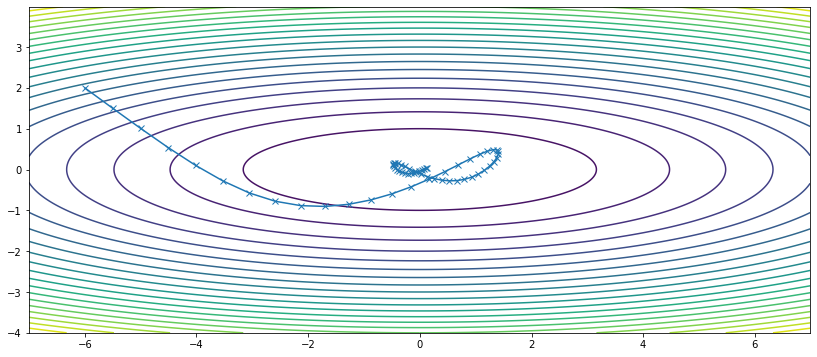

In [17]:
visualize_optimizer(Adam, n_steps=60, learning_rate=0.5, beta1=0.9, beta2=0.999, epsilon=1e-8)